Dataset Shape: (47849, 6)
  type                                            content  \
0    p  ক্রমণকে পরাস্ত করে, অভাবনীয় দুর্গম, দীর্ঘ পথ ...   
1   ol                            4১ 09৮80, ০০ ০4, 9 133.   
2    p  ১৩ই এপ্রিল (২৬) ১৯১১ সালে কারখান] ডাক্তার ও শি...   
3   li      সুভাবরঞ্জন চক্রবর্তী, পূর্বোক্ত গ্রহ, পৃ 102.   
4    p  অহস্বলাভ করিয়া ভিক্ষু দাসক [ভক্ষ; উপাঁলর হাজা...   

                                               title  \
0  ক্রমণকে পরাস্ত করে, অভাবনীয় দুর্গম, দীর্ঘ পথ ...   
1                            4১ 09৮80, ০০ ০4, 9 133.   
2  ১৩ই এপ্রিল (২৬) ১৯১১ সালে কারখান] ডাক্তার ও শি...   
3      সুভাবরঞ্জন চক্রবর্তী, পূর্বোক্ত গ্রহ, পৃ 102.   
4  অহস্বলাভ করিয়া ভিক্ষু দাসক [ভক্ষ; উপাঁলর হাজা...   

                                             context     label class  
0  ক্রমণকে পরাস্ত করে, অভাবনীয় দুর্গম, দীর্ঘ পথ ...  positive  news  
1                           4১ 09৮80, ০০ ০4, 9 133.।  negative  news  
2  ১৩ই এপ্রিল (২৬) ১৯১১ সালে কারখান] ডাক্তার ও শি...  neg

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 9570/9570 [00:01<00:00, 8528.05 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_258560\1636855775.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.950700,1.444276,0.350261,0.181717
2,0.900500,1.348418,0.350261,0.181717
3,1.009700,1.620786,0.350261,0.181717


Evaluation results: {'eval_loss': 1.3484184741973877, 'eval_accuracy': 0.35026123301985373, 'eval_f1': 0.18171732751625902, 'eval_runtime': 49.8223, 'eval_samples_per_second': 192.083, 'eval_steps_per_second': 24.025, 'epoch': 3.0}
Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00      4757
     neutral       0.00      0.00      0.00      1461
    positive       0.35      1.00      0.52      3352

    accuracy                           0.35      9570
   macro avg       0.12      0.33      0.17      9570
weighted avg       0.12      0.35      0.18      9570



c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


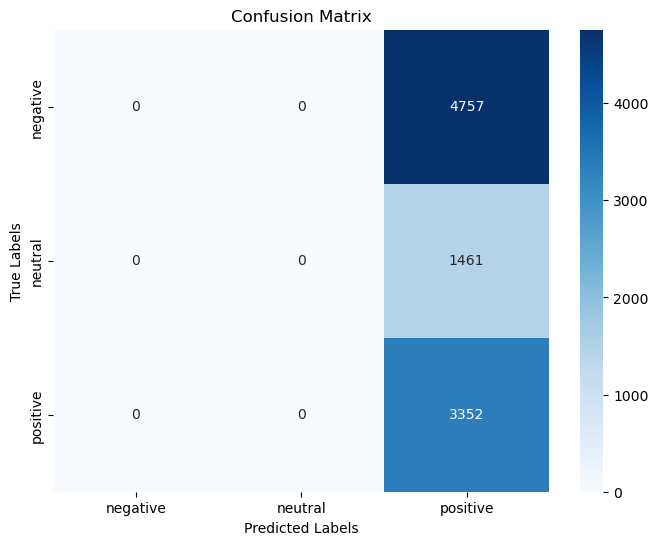

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
df = pd.read_csv("fdata.csv")
print("Dataset Shape:", df.shape)
print(df.head())

# Check for missing values
df.dropna(inplace=True)

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract features and labels
X = df['context']
y = df['label']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to Hugging Face dataset
data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data = data.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'xlm-roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text']).rename_column('label', 'labels')
data.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[]
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate predictions
predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Class Weights: tensor([4.2027e-05, 1.3541e-04, 5.9988e-05])


Map: 100%|██████████| 9570/9570 [00:00<00:00, 14006.22 examples/s]
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_258560\2247861941.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.818700,0.780828,0.688088,0.693291
2,0.838200,0.736596,0.715987,0.717112
3,0.739400,0.761892,0.704598,0.708516
4,0.368000,0.825174,0.736155,0.737438
5,0.394400,0.966193,0.728945,0.730035
6,0.435900,1.130620,0.729781,0.730690


Evaluation results: {'eval_loss': 0.8251743912696838, 'eval_accuracy': 0.7361546499477534, 'eval_f1': 0.7374379610920228, 'eval_runtime': 13.659, 'eval_samples_per_second': 700.635, 'eval_steps_per_second': 87.634, 'epoch': 6.0}
Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.79      0.80      4757
     neutral       0.55      0.58      0.56      1461
    positive       0.72      0.73      0.72      3352

    accuracy                           0.74      9570
   macro avg       0.69      0.70      0.70      9570
weighted avg       0.74      0.74      0.74      9570



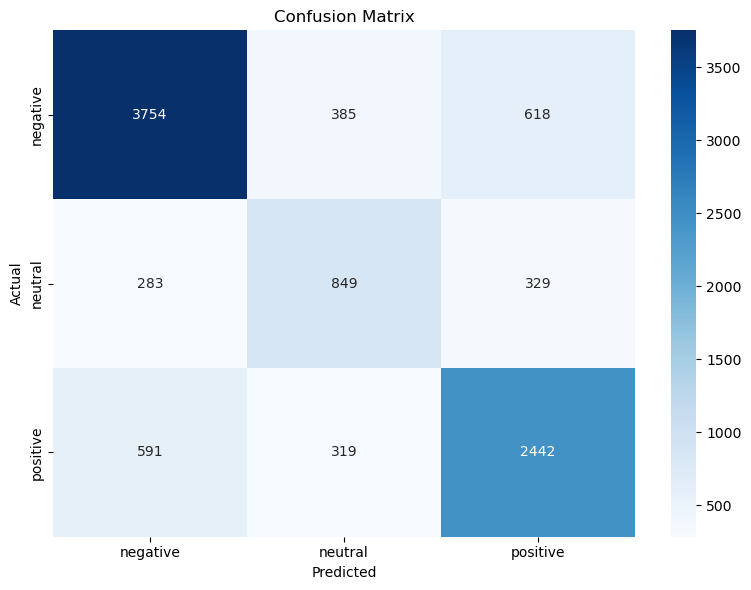

In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from torch.nn import CrossEntropyLoss

# Load dataset
df = pd.read_csv("fdata.csv")
df.dropna(inplace=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Compute class weights
class_counts = df['label'].value_counts().sort_index().values
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32)
print("Class Weights:", class_weights)

# Convert to HuggingFace dataset
dataset = Dataset.from_pandas(df[['context', 'label']].rename(columns={'context': 'text'}))
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load tokenizer
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=256)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text'])
dataset = dataset.rename_column('label', 'labels')
dataset.set_format('torch')

# Custom Trainer to use weighted loss
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.model.device) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.class_weights is not None:
            loss_fct = CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fct = CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./sentiment-checkpoints',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=20,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[],
    fp16=torch.cuda.is_available()
)

# Evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Create Trainer
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Predictions
pred_output = trainer.predict(dataset['test'])
preds = np.argmax(pred_output.predictions, axis=1)
true_labels = pred_output.label_ids

# Classification Report
report = classification_report(true_labels, preds, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
